In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pylab import plot,show,hist, rcParams 
rcParams['figure.figsize'] = 8, 5

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('data/Kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

## Решение

### Часть I: Первичный анализ данных

Посмотрим какие у нас пизнаки и расшифруем их названия:

- action_type
- combined_shot_type
- game_event_id
- game_id
- lat
- loc_x
- loc_y
- lon
- minutes_remaining
- period
- playoffs
- season 
- seconds_remaining
- shot_distance
- shot_made_flag (this is what you are predicting)
- shot_type
- shot_zone_area
- shot_zone_basic
- shot_zone_range
- team_id
- team_name
- game_date
- matchup
- opponent
- shot_id

###### Посмотрим на типы данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [6]:
sum(data['shot_made_flag'].isnull())

5000

In [3]:
data['new_target'] = np.ceil(data['shot_made_flag'])

In [8]:
sum(data['new_target'].isnull())

5000

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 26 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [10]:
#посмотрим какие есть признаки в нашем dataFrame
[x for x in data.columns]

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id',
 'new_target']

In [11]:
#посмотрим какое кол-во строк и столбцов в нашем dataFrame
print(data.shape)

(30697, 26)


In [12]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,new_target
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,NaN
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,0.0
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,1.0
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,0.0
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,1.0


In [13]:
#посмотрим какие броски выполнял Коби (посмотрим в абсолютных величинах)
data['combined_shot_type'].value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64

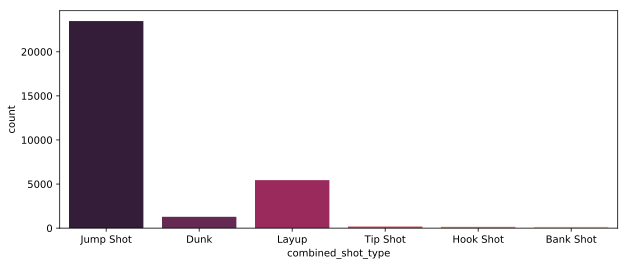

In [10]:
#визуализируем наши цифры
fig, ax = plt.subplots()
#protect our eyes возьмем размер побольше
fig.set_size_inches(10, 4)

sns.countplot(data['combined_shot_type'], palette= 'rocket')

In [11]:
#посмотрим какие броски выполнял Коби (посмотрим в относительных величинах)
data['combined_shot_type'].value_counts()/data['combined_shot_type'].count()

Jump Shot    0.765058
Layup        0.177477
Dunk         0.041893
Tip Shot     0.005994
Hook Shot    0.004984
Bank Shot    0.004593
Name: combined_shot_type, dtype: float64

Коби любит бросать `Jump Shot` такие броски состовляют 76,7% от общего кол-ва, следующий бросок это Лай-ап 17,6%

In [12]:
#посмотрим с какой дистанции Коби чаше всего совершал броски
data['shot_zone_range'].value_counts()

Less Than 8 ft.    9398
16-24 ft.          8315
8-16 ft.           6626
24+ ft.            6275
Back Court Shot      83
Name: shot_zone_range, dtype: int64

Коби чаще всего бросает из под кольца 7857 бросков, интересно но следующее расстояние это расстояние от 4,8 м до 7,3 м 6907, это очень интересно

In [13]:
#посмотрим какое распределение реализованных и не реализованных брасков в зависимости от их типа 
data[['combined_shot_type', 'shot_made_flag', 'action_type']]\
        .groupby(['combined_shot_type', 'shot_made_flag']).agg('count').reset_index()

,combined_shot_type,shot_made_flag,action_type
0,Bank Shot,0.0,25
1,Bank Shot,1.0,95
2,Dunk,0.0,76
3,Dunk,1.0,980
4,Hook Shot,0.0,59
5,Hook Shot,1.0,68
6,Jump Shot,0.0,12002
7,Jump Shot,1.0,7708
8,Layup,0.0,1971
9,Layup,1.0,2561


In [14]:
#посмотрим на распределение кол-ва бросков по периодам
data['period'].value_counts()

3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64

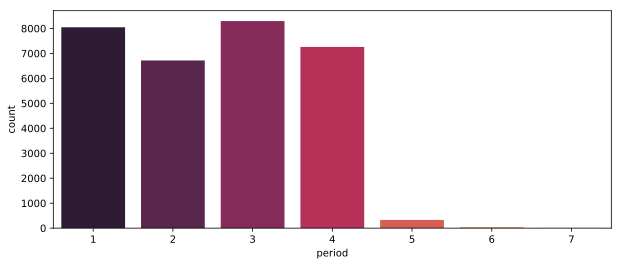

In [15]:
#визуализируем наши результаты
fig, ax = plt.subplots()
#protect our eyes возьмем размер побольше
fig.set_size_inches(10, 4)

sns.countplot(data['period'], palette= 'rocket')

Два интересных факта можно отметить из распределения кол-ва бросков по четвертям:
- первое, это то что Коби сделал 7 бросков в третьем овертайме, тоесть была как минимум одна игра где было три овертайма (мне кажется это очень интересный факт)
- второй момент который можно отметить это то что продуктивность Коби резко снижается во второй четверти по сравнению с 1 и 3, это может быть связанно с тем что стратегия заключается в том чтобы максимально загружать Коби в первой и третей четверти, тогда можно сделать вывод что стратегия Lakers (времен Коби) представляла из себя достаточно прогматичную игру и подразумевала набрать максимальное кол-во очков в первой и третьей четверти и играть осторожно на результат в четвертой 

In [16]:
firs_period = data[data['period'] == 1]
second_period = data[data['period'] == 2]
third_period = data[data['period'] == 3]
fourth_period = data[data['period'] == 4]

In [17]:
#напишим маленькую функцию которая будет возвращать средние значения кол-ва бросков в каждом периоде 
def shots_mean_value(per1, per2, per3, per4):
    m1 = per1.groupby('game_id')['shot_id'].count().mean()
    m2 = per2.groupby('game_id')['shot_id'].count().mean()
    m3 = per3.groupby('game_id')['shot_id'].count().mean()
    m4 = per4.groupby('game_id')['shot_id'].count().mean()
    return m1, m2, m3, m4

In [18]:
#ну что посмотрим что мы имеем
shots_mean_value(firs_period, second_period, third_period, fourth_period)

(5.397719651240778, 4.484646194926569, 5.616790792146243, 5.307017543859649)

Коби всреднем больше всего бросков совершал в третьей и первой четверти, а это значит что наша гипотеза верна

In [19]:
#можем еще посмотреть на ср знач кол-ва бросков за игру
data.groupby('game_id')['shot_id'].count().mean()

19.69018601667736

In [20]:
#посмотрим сколько в среднем за игру бросков Коби были реализованны
data[data['shot_made_flag']==1].groupby('game_id')['shot_id'].count().mean()

7.469055374592834

In [21]:
#посмотрим сколько в среднем за игру бросков Коби не были реализованны
data[data['shot_made_flag']==0].groupby('game_id')['shot_id'].count().mean()

9.187863137508069

In [22]:
#посмотрим сколько в каждом сезоне Коби совершал бросков
data[['season', 'shot_made_flag']].groupby(['season'], as_index=False)\
.count().sort_values(by='season', ascending=True).style.bar()

,season,shot_made_flag
0,1996-97,383
1,1997-98,810
2,1998-99,765
3,1999-00,1312
4,2000-01,1575
5,2001-02,1708
6,2002-03,1852
7,2003-04,1371
8,2004-05,1127
9,2005-06,1924


Высокие результаты Коби показывает в период с сезона 1999 - 00 и до сезона 2012 - 2013 при этом самое большое кол-во бросков приходится на сезон 2005 - 06

In [23]:
#посмотрим на распределение реализованных и не реализованных брасков в зависимости от периода
data[['period', 'shot_made_flag', 'action_type']]\
        .groupby(['period', 'shot_made_flag']).agg('count').reset_index()

,period,shot_made_flag,action_type
0,1,0.0,3580
1,1,1.0,3120
2,2,0.0,3106
3,2,1.0,2529
4,3,0.0,3827
5,3,1.0,3175
6,4,0.0,3543
7,4,1.0,2500
8,5,0.0,156
9,5,1.0,124


Построим корреляционнную матрицу и посмотрим как признаки коррелируют между собой

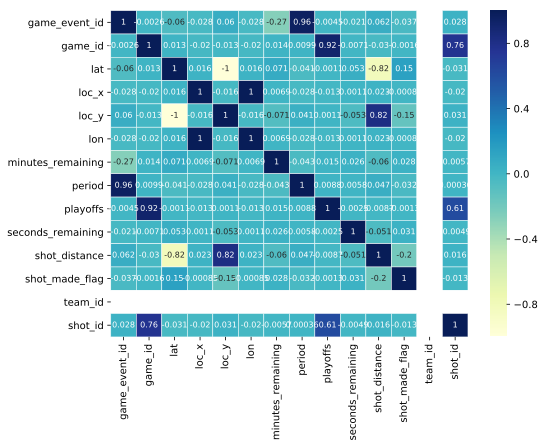

In [24]:
%config InlineBackend.figure_format = 'svg' 
fig, ax = plt.subplots()
#protect our eyes возьмем размер побольше
fig.set_size_inches(8, 6)
corr = data.corr()
sns.heatmap(corr, annot=True, linewidths=.5,cmap="YlGnBu", linecolor='white', annot_kws={"size": 8},\
            xticklabels=corr.columns.values, yticklabels=corr.columns.values)

###### Выполним небольшую отчистку данных, оставим данные где нет пропущенных значений признака `shot_made_flag`

In [25]:
#clean_data =  data[pd.notnull(data['shot_made_flag'])]

#Отлично, теперь посмотрим что у нас получилось
#clean_data.info()

In [26]:
#print(clean_data.shape)

### Часть II Подготовка фичей для обучения модели

В этой часте мы подготовим фичи для обучения модели - нагенерируем признаков, обработаем пропущенные значения, проверим наличие возможных выбросов и обработаем категориальные признаки.

#### Сгенерируем пару новых фичей (`home_or_away`, `best_seasons`, `remaining_time` ,`last_years_of_career`)

#### 1. Фича `home_or_away`

игра была дома или в гостях, данная фича может быть полезна с точки зрения психологии игрока и команды, как говорят знатоки игровых видов спорта, дома играть легче, это достигается за счет своего стадиона и болельщиков (родные стены помогают так сказать)

In [5]:
#добовляем новый признак home_or_away
data.loc[data.matchup.str.find('@')==-1, 'home_or_away'] = 1
data.loc[data.matchup.str.find('vs')==-1, 'home_or_away'] = 0

In [6]:
#посмотрим на распределение
data['home_or_away'].value_counts()

0.0    15741
1.0    14956
Name: home_or_away, dtype: int64

In [7]:
#а теперь проверим можноли экстраполировать мудрость спортивных экспертов на Коби
data[['home_or_away', 'shot_made_flag', 'shot_id']].groupby(['home_or_away', 'shot_made_flag'])\
                .agg('count').reset_index()

,home_or_away,shot_made_flag,shot_id
0,0.0,0.0,7446
1,0.0,1.0,5766
2,1.0,0.0,6786
3,1.0,1.0,5699


Забавно но на Коби закон родных стен не распространяется, вот так вот открытие

#### 2. Фича `best_seasons`

как мы определили ранее самый продуктивный период карьеры Коби приходится на период с 2000 по 2013 год, наша фича `best_years` будет будет разделять карьеру Коби на два этапа, так сказать лучшие годы (период до 2013 года) и закат карьеры (период после 2013 года)

In [8]:
data['season_year'] = data.season.str.split('-').str[0]
data['season_year'] = data['season_year'].astype(int)

In [9]:
def best_years(year):
    if 2000 <= year < 2014:
        return 1
    else:
        return 0

In [10]:
data['best_seasons'] = data.apply(lambda row: best_years(row.season_year), axis=1)

In [11]:
data.shape

(30697, 29)

#### 3. Фича `remaining_time`

данная фича показывает что бросок был выполнен за 2 минуты до конца четвертой четверти, данная фича должна показать как часто Коби бросает в концовке матча


In [12]:
def check_period(period):
    """
    
    """
    if period == 4:
        return 1
    else:
        return 0

def part_of_last_period(per, mins):
    """
    
    """
    if per == 4 and mins <= 2:
        return 1
    else:
        return 0 

In [13]:
data['period_check'] = data.apply(lambda row: check_period(row.period), axis=1)

In [14]:
data['remaining_time'] = data.apply(lambda row: part_of_last_period(row.period, row.minutes_remaining), axis=1)

In [15]:
data.shape

(30697, 31)

In [16]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,game_date,matchup,opponent,shot_id,new_target,home_or_away,season_year,best_seasons,period_check,remaining_time
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2000-10-31,LAL @ POR,POR,1,NaN,0.0,2000,1,0,0
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2000-10-31,LAL @ POR,POR,2,0.0,0.0,2000,1,0,0
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2000-10-31,LAL @ POR,POR,3,1.0,0.0,2000,1,0,0
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2000-10-31,LAL @ POR,POR,4,0.0,0.0,2000,1,0,0
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2000-10-31,LAL @ POR,POR,5,1.0,0.0,2000,1,0,0


#### 4. Фича `last_years_of_career`

данная фича показывает что это последний или не последний сезон в карьере Коби

In [17]:
def last_year(year1):
    """
    
    """
    if year1 >= 2014:
        return 1
    else:
        return 0

In [18]:
data['last_years_of_career'] = data.apply(lambda row: last_year(row.season_year), axis=1)

In [19]:
data.shape

(30697, 32)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 32 columns):
action_type             30697 non-null object
combined_shot_type      30697 non-null object
game_event_id           30697 non-null int64
game_id                 30697 non-null int64
lat                     30697 non-null float64
loc_x                   30697 non-null int64
loc_y                   30697 non-null int64
lon                     30697 non-null float64
minutes_remaining       30697 non-null int64
period                  30697 non-null int64
playoffs                30697 non-null int64
season                  30697 non-null object
seconds_remaining       30697 non-null int64
shot_distance           30697 non-null int64
shot_made_flag          25697 non-null float64
shot_type               30697 non-null object
shot_zone_area          30697 non-null object
shot_zone_basic         30697 non-null object
shot_zone_range         30697 non-null object
team_id                

#### Обработаем категориальные фичи:
(`combined_shot_type`, `shot_type`, `shot_zone_area` ,`shot_zone_basic`, `shot_zone_range`, `opponent`)

для этого будем использовать метод WOE

In [43]:
"""
#переведем категориальные признаки в количественные для этого будем использовать функцию get_one_hot
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df
"""

'\n#переведем категориальные признаки в количественные для этого будем использовать функцию get_one_hot\ndef get_one_hot(df, cols):\n    for each in cols:\n        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)\n        df = pd.concat([df, dummies], axis=1)\n    return df\n'

In [21]:
#переведем категориальные признаки в количественные для этого будем использовать функцию get_woe_v1
def get_woe_v1(df_train, col, target_col):
    """
    
    """
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    
    return df_train

In [22]:
#выберем категориальные признаки которые будем переводить в количественные 
columns_to_get_counts = [
    'combined_shot_type',
    'shot_type',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'opponent', 
]
    
for col_get_prob in columns_to_get_counts:
    prepared_data = get_woe_v1(data, col_get_prob, 'shot_made_flag')

In [33]:
 prepared_data.shape

(30697, 38)

In [34]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 38 columns):
action_type               30697 non-null object
combined_shot_type        30697 non-null object
game_event_id             30697 non-null int64
game_id                   30697 non-null int64
lat                       30697 non-null float64
loc_x                     30697 non-null int64
loc_y                     30697 non-null int64
lon                       30697 non-null float64
minutes_remaining         30697 non-null int64
period                    30697 non-null int64
playoffs                  30697 non-null int64
season                    30697 non-null object
seconds_remaining         30697 non-null int64
shot_distance             30697 non-null int64
shot_made_flag            25697 non-null float64
shot_type                 30697 non-null object
shot_zone_area            30697 non-null object
shot_zone_basic           30697 non-null object
shot_zone_range           30697 n

In [23]:
prepared_data_1 = prepared_data.drop(
                    labels=['action_type', 'combined_shot_type', 'season', 
                    'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 
                    'team_name', 'game_date','matchup', 'opponent'],
                    axis=1
                    )

In [24]:
prepared_data_1.shape

(30697, 27)

In [37]:
[x for x in prepared_data_1.columns]

['game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'team_id',
 'shot_id',
 'new_target',
 'home_or_away',
 'season_year',
 'best_seasons',
 'period_check',
 'remaining_time',
 'last_years_of_career',
 'combined_shot_type_woe',
 'shot_type_woe',
 'shot_zone_area_woe',
 'shot_zone_basic_woe',
 'shot_zone_range_woe',
 'opponent_woe']

In [25]:
without_data = prepared_data_1[pd.isnull(prepared_data_1['shot_made_flag'])]

In [39]:
without_data.shape

(5000, 27)

In [26]:
clean_data =  prepared_data_1[pd.notnull(data['shot_made_flag'])]
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 27 columns):
game_event_id             25697 non-null int64
game_id                   25697 non-null int64
lat                       25697 non-null float64
loc_x                     25697 non-null int64
loc_y                     25697 non-null int64
lon                       25697 non-null float64
minutes_remaining         25697 non-null int64
period                    25697 non-null int64
playoffs                  25697 non-null int64
seconds_remaining         25697 non-null int64
shot_distance             25697 non-null int64
shot_made_flag            25697 non-null float64
team_id                   25697 non-null int64
shot_id                   25697 non-null int64
new_target                25697 non-null float64
home_or_away              25697 non-null float64
season_year               25697 non-null int64
best_seasons              25697 non-null int64
period_check              25697 non

In [28]:
clean_data.shape

(25697, 28)

In [29]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 28 columns):
game_event_id             25697 non-null int64
game_id                   25697 non-null int64
lat                       25697 non-null float64
loc_x                     25697 non-null int64
loc_y                     25697 non-null int64
lon                       25697 non-null float64
minutes_remaining         25697 non-null int64
period                    25697 non-null int64
playoffs                  25697 non-null int64
seconds_remaining         25697 non-null int64
shot_distance             25697 non-null int64
shot_made_flag            25697 non-null float64
team_id                   25697 non-null int64
shot_id                   25697 non-null int64
new_target                25697 non-null float64
home_or_away              25697 non-null float64
season_year               25697 non-null int64
best_seasons              25697 non-null int64
period_check              25697 non

0.0

In [70]:
prepared_data_2 = clean_data.drop(
                    labels=['game_event_id', 'game_id', 'period', 
                    'playoffs', 'team_id', 'shot_id' ],
                    axis=1
                    )

In [71]:
prepared_data_2.shape

(25697, 22)

In [72]:
X = prepared_data_2.drop('shot_made_flag', axis=1)
y = prepared_data_2[['shot_made_flag']]

In [ ]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Зависимость от компонент', fontsize=20)
fig, axes = plt.subplots(1, 22, sharey=True)
y_col = 'shot_zone_basic_woe'
for i, x_col in enumerate(prepared_data_2.columns.drop(y_col)):
    prepared_data_2.plot.scatter(x_col, y_col, ax=axes[i])
    
    lm = LinearRegression().fit(
        prepared_data_2[x_col].values.reshape(-1, 1), 
        prepared_data_2[y_col].values.reshape(-1, 1)
    )
    xs = np.array([prepared_data_2[x_col].min(), prepared_data_2[x_col].max()]).reshape(-1, 1)
    ys = lm.predict(xs)
    axes[i].plot(xs, ys, c='r', linewidth=2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [62]:
from sklearn.model_selection import train_test_split

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [63]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for lat is 2.791618920307934e-08
The coefficient for loc_x is 5.060291402607549e-05
The coefficient for loc_y is -2.791618919342931e-05
The coefficient for lon is 5.060291387391086e-08
The coefficient for minutes_remaining is 0.0032083267040943376
The coefficient for seconds_remaining is 0.0006757918702026112
The coefficient for shot_distance is -0.0036077016473562125
The coefficient for home_or_away is 0.005973787757480975
The coefficient for season_year is 0.002705270919004202
The coefficient for best_seasons is -0.007835219091069975
The coefficient for period_check is -0.021848668727546393
The coefficient for remaining_time is -0.021098672121733497
The coefficient for last_years_of_career is -0.08123693767833062
The coefficient for combined_shot_type_woe is 0.1549737471335459
The coefficient for shot_type_woe is 0.06515130449817978
The coefficient for shot_zone_area_woe is 0.053065492669658224
The coefficient for shot_zone_basic_woe is 0.00015321179944837587
The coef

In [65]:
intercept = regression_model.intercept_[0]

print("The intercept for our model is {}".format(intercept))

The intercept for our model is -4.953806859744875


In [66]:
regression_model.score(X_test, y_test)

0.07265097166843015

In [67]:
from sklearn.metrics import mean_squared_error

y_predict = regression_model.predict(X_test)

regression_model_mse = mean_squared_error(y_predict, y_test)

regression_model_mse

0.22961999430916488

In [68]:
import math

math.sqrt(regression_model_mse)

0.4791868052327452

In [71]:
print("Residual sum of squares: %.2f"
  % ((regression_model.predict(X_train) - y_train) ** 2).sum())

Residual sum of squares: 4135.81


In [74]:
from sklearn.linear_model import LinearRegression

def linear_regression(data, power, models_to_plot):
    # predictors:
    predictors=['shot_type_woe']
    #if power >= 2:
        #predictors.extend(['x_%d' % i for i in range(2, power + 1)])
    
    # fit
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors], data['shot_made_flag'])
    y_pred = linreg.predict(data[predictors])
    
    # models to plot
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['shot_type_woe'], y_pred)
        plt.plot(data['shot_type_woe'], data['shot_made_flag'], '.')
        plt.title('Plot for power: %d' % power)
    
    # Return the result in pre-defined format
    rss = sum((y_pred - data['shot_made_flag']) ** 2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

In [75]:
#Initialize a dataframe to store the results:
col = ['rss', 'intercept'] + ['coef_x_%d' % i for i in range(1, 16)]
ind = ['model_pow_%d' % i for i in range(1, 16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1: 231, 3: 232, 6: 233, 9: 234, 12: 235, 15: 236}

#Iterate through all powers and assimilate results
for i in range(1, 16):
    coef_matrix_simple.iloc[i - 1, 0:i + 2] = linear_regression(
        clean_data,
        power=i,
        models_to_plot=models_to_plot
    )

ValueError: cannot copy sequence with size 3 to array axis with dimension 4

In [ ]:
# Set the display float format
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

In [55]:
data['playoffs'].value_counts()

0    26198
1     4499
Name: playoffs, dtype: int64

In [47]:
data.groupby('playoffs')['shot_made_flag'].value_counts()

playoffs  shot_made_flag
0         0.0               12145
          1.0                9794
1         0.0                2087
          1.0                1671
Name: shot_made_flag, dtype: int64

In [57]:
data['minutes_remaining'].describe()

count    30697.000000
mean         4.885624
std          3.449897
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         11.000000
Name: minutes_remaining, dtype: float64

In [52]:
data_1 = data.drop(
        labels=['action_type', 'combined_shot_type', 'seconds_remaining', 
         'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_name', 'game_date',
        'matchup', 'opponent'],
        axis=1
    )

In [19]:
#переведем категориальные признаки в количественные для этого будем использовать функцию get_one_hot
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [20]:
clean_data = get_one_hot(
        clean_data,
        ['action_type', 'combined_shot_type', 'seconds_remaining', 'season', 
         'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_name', 'game_date',
        'matchup', 'opponent']
    )

In [21]:
clean_data.shape

(25697, 1852)

In [22]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Columns: 1852 entries, action_type to opponent_WAS
dtypes: float64(3), int64(11), object(11), uint8(1827)
memory usage: 51.1+ MB


In [23]:
clean_data = clean_data.drop(
        labels=['action_type', 'combined_shot_type', 'seconds_remaining', 'season', 
         'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_name', 'game_date',
        'matchup', 'opponent'],
        axis=1
    )

In [24]:
clean_data.shape

(25697, 1840)

In [25]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Columns: 1840 entries, game_event_id to opponent_WAS
dtypes: float64(3), int64(10), uint8(1827)
memory usage: 48.8 MB


In [ ]:
court_scale, alpha = 7, 0.05
plt.figure(figsize=(12,8))

plt.subplot(121)
h = clean_data.loc[clean_data.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha=alpha)
plt.title('Реализованный бросок')
ax = plt.gca()
ax.set_ylim([-50, 900])


plt.subplot(122)
h = clean_data.loc[clean_data.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha=alpha)
plt.title('Нереализованный бросок')
ax = plt.gca()
ax.set_ylim([-50, 900])